In [1]:
# Step-1: import libraries

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score,make_scorer


In [2]:
# Step-2: identify file path

for dirname,_,filenames in os.walk('/kaggle/input'):
    for file in filenames:
        path=os.path.join(dirname,file)
        print(path)

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [3]:
# Step-3: Load Dataset

df=pd.read_csv(path)
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
# Drop unnecessary column

df=df.drop(columns=['Unnamed: 0']) 
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
#check data info + null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [6]:
df['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [7]:
df['status']=df['status'].map({
    'Normal':0,
    'Depression':1,
    'Suicidal':2,
    'Anxiety':3,
    'Bipolar':4,
    'Stress':5,
    'Personality disorder':6
})

label=['Normal','Depression','Suicidal','Anxiety','Bipolar','Stress','Personality disorder']

In [8]:
df['status'].value_counts()

status
0    16351
1    15404
2    10653
3     3888
4     2877
5     2669
6     1201
Name: count, dtype: int64

In [9]:
df['statement'].fillna('NAN',inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  53043 non-null  object
 1   status     53043 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 828.9+ KB


In [11]:
# Split dataset

x=df['statement']
y=df['status']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

# Pipeline+ Hyperparameter Tuning (GridSearchCV) for Logistic Regression 

In [12]:

pipe_log=Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english',max_features=20000,lowercase=True)),
    ('clf',LogisticRegression(max_iter=5000))
])

log_para_grid={
    'tfidf__ngram_range':[(1,1),(1,2)],
    'clf__C':[0.01,0.1,1],
    'clf__penalty':['l1','l2'],
    'clf__solver':['liblinear','saga']
}

sc={
    'f1_macro':make_scorer(f1_score,average='macro'),
    'f1_wieghted':make_scorer(f1_score,average='weighted'),
    'f1_micro':make_scorer(f1_score,average='micro')
}

log_grid=GridSearchCV(pipe_log,log_para_grid,cv=5,scoring=sc,refit='f1_macro',n_jobs=-1,verbose=1)

In [13]:

log_grid.fit(x_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=20000,
                                                        stop_words='english')),
                                       ('clf',
                                        LogisticRegression(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1], 'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear', 'saga'],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             refit='f1_macro',
             scoring={'f1_macro': make_scorer(f1_score, average=macro),
                      'f1_micro': make_scorer(f1_score, average=micro),
                      'f1_wieghted': make_scorer(f1_score, average=weighted)},
             verbose=1)

Accuracy Score: 76.12%
Classification report for Best Logistic Regression :
                      precision    recall  f1-score   support

              Normal       0.85      0.94      0.89      3270
          Depression       0.70      0.74      0.72      3081
            Suicidal       0.70      0.68      0.69      2131
             Anxiety       0.80      0.73      0.77       778
             Bipolar       0.91      0.68      0.78       575
              Stress       0.67      0.40      0.50       534
Personality disorder       0.63      0.51      0.56       240

            accuracy                           0.76     10609
           macro avg       0.75      0.67      0.70     10609
        weighted avg       0.76      0.76      0.76     10609



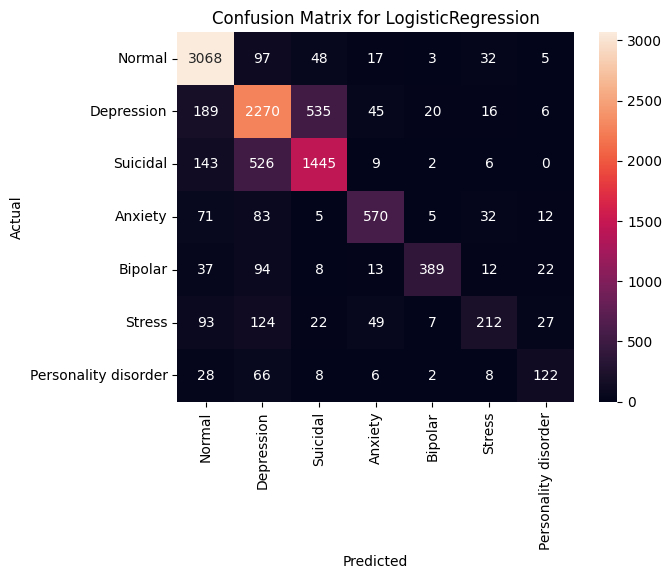

Best paramer:  {'clf__C': 1, 'clf__penalty': 'l1', 'clf__solver': 'saga', 'tfidf__ngram_range': (1, 2)}


In [14]:
# Prediction and Evaluatoion

log_pred=log_grid.predict(x_test)

acc_log=accuracy_score(y_test,log_pred)
report_log=classification_report(y_test,log_pred,target_names=label)
cm=confusion_matrix(y_test,log_pred)

print(f"Accuracy Score: {acc_log*100:.2f}%")
print(f'Classification report for Best Logistic Regression :\n{report_log}')
sns.heatmap(cm,annot=True,fmt='d',xticklabels=label,yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LogisticRegression')
plt.show()

print('Best paramer: ',log_grid.best_params_)

# Pipeline+ Hyperparameter Tuning (GridSearchCV) for Multinomial Naive Bayes

In [15]:
pipe_nb=Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english',max_features=5000,lowercase=True)),('NB',MultinomialNB())
])

nb_para_grid={
    'tfidf__ngram_range':[(1,1),(1,2)],
    'NB__alpha':[0.5,1.0]
}

nb_grid=GridSearchCV(pipe_nb,nb_para_grid,cv=5,scoring=sc,refit='f1_macro',n_jobs=-1,verbose=1)


In [16]:
nb_grid.fit(x_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words='english')),
                                       ('NB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'NB__alpha': [0.5, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             refit='f1_macro',
             scoring={'f1_macro': make_scorer(f1_score, average=macro),
                      'f1_micro': make_scorer(f1_score, average=micro),
                      'f1_wieghted': make_scorer(f1_score, average=weighted)},
             verbose=1)

Accuracy Score: 69.27%
Classification Report: 
                        precision    recall  f1-score   support

              Normal       0.83      0.83      0.83      3270
          Depression       0.56      0.76      0.64      3081
            Suicidal       0.71      0.61      0.66      2131
             Anxiety       0.77      0.64      0.70       778
             Bipolar       0.87      0.52      0.65       575
              Stress       0.78      0.18      0.30       534
Personality disorder       0.55      0.30      0.39       240

            accuracy                           0.69     10609
           macro avg       0.72      0.55      0.60     10609
        weighted avg       0.71      0.69      0.69     10609



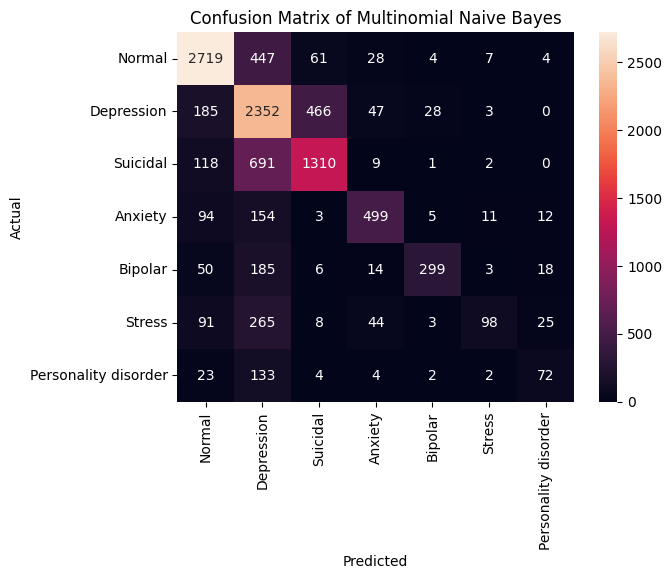

{'NB__alpha': 0.5, 'tfidf__ngram_range': (1, 2)}


In [17]:
# Prediction and Evaluatoion

nb_pred=nb_grid.predict(x_test)
acc_nb=accuracy_score(y_test,nb_pred)
report_nb=classification_report(y_test,nb_pred,target_names=label)
cm=confusion_matrix(y_test,nb_pred)

print(f'Accuracy Score: {acc_nb*100:.2f}%')
print(f'Classification Report: \n ',report_nb)

sns.heatmap(cm,annot=True,fmt='d',xticklabels=label,yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Multinomial Naive Bayes')
plt.show()

print(nb_grid.best_params_)

# Pipeline+ Hyperparameter Tuning (GridSearchCV) for LinearSVC

In [18]:
pipe_svm=Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english',lowercase=True,max_features=5000)),
    ('svm',LinearSVC(max_iter=5000))
])

para_grid_svm={
    'tfidf__ngram_range':[(1,1),(1,2),(1,3)],
    'svm__C':[0.01,0.1,1,5]
}

svm_grid=GridSearchCV(pipe_svm,para_grid_svm,cv=5,scoring=sc,refit='f1_macro',n_jobs=-1,verbose=1)
svm_grid.fit(x_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words='english')),
                                       ('svm', LinearSVC(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.01, 0.1, 1, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             refit='f1_macro',
             scoring={'f1_macro': make_scorer(f1_score, average=macro),
                      'f1_micro': make_scorer(f1_score, average=micro),
                      'f1_wieghted': make_scorer(f1_score, average=weighted)},
             verbose=1)

Accuracy Score: 76.36%
Classification Report: 
                        precision    recall  f1-score   support

              Normal       0.85      0.94      0.90      3270
          Depression       0.71      0.72      0.71      3081
            Suicidal       0.68      0.66      0.67      2131
             Anxiety       0.80      0.75      0.78       778
             Bipolar       0.87      0.71      0.78       575
              Stress       0.64      0.47      0.54       534
Personality disorder       0.63      0.61      0.62       240

            accuracy                           0.76     10609
           macro avg       0.74      0.70      0.72     10609
        weighted avg       0.76      0.76      0.76     10609



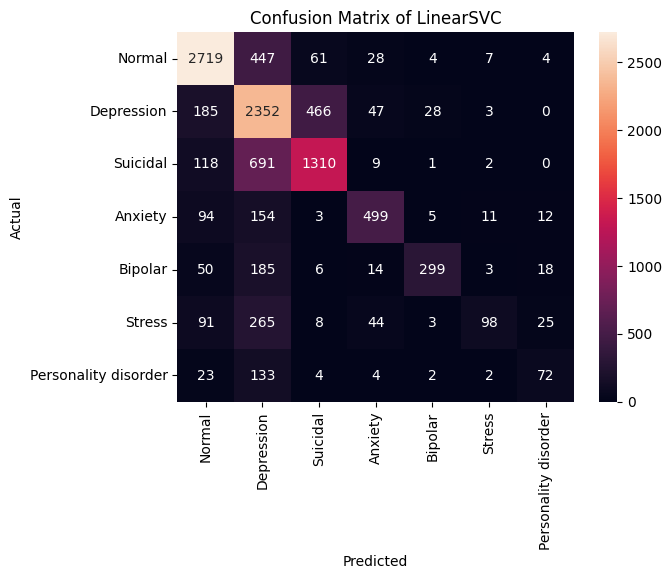

{'svm__C': 1, 'tfidf__ngram_range': (1, 1)}


In [19]:
# Prediction and Evaluatoion

svm_pred=svm_grid.predict(x_test)
acc_svm=accuracy_score(y_test,svm_pred)
report_svm=classification_report(y_test,svm_pred,target_names=label)
cm=confusion_matrix(y_test,nb_pred)

print(f'Accuracy Score: {acc_svm*100:.2f}%')
print(f'Classification Report: \n ',report_svm)

sns.heatmap(cm,annot=True,fmt='d',xticklabels=label,yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of LinearSVC')
plt.show()

print(svm_grid.best_params_)

In [30]:
# Result
log_f1=f1_score(y_test,log_pred,average='macro')*100
nb_f1=f1_score(y_test,nb_pred,average='macro')*100
svc_f1=f1_score(y_test,svm_pred,average='macro')*100

f1_macro=[f'{log_f1:.2f}%',f'{nb_f1:.2f}%',f'{svc_f1:.2f}%']
acc=[f'{acc_log*100:.2f}%',f'{acc_nb*100:.2f}%',f'{acc_svm*100:.2f}%']
model=['LogisticRegression','NaiveBayes','LinearSVC']
best_param=[log_grid.best_params_,nb_grid.best_params_,svm_grid.best_params_]

Results=pd.DataFrame({
    'Model':model,
    'Accuracy':acc,
    'F1-macro':f1_macro,
    'Best_param':best_param
})

In [31]:
print(Results.head().to_string())

                Model Accuracy F1-macro                                                                                Best_param
0  LogisticRegression   76.12%   69.93%  {'clf__C': 1, 'clf__penalty': 'l1', 'clf__solver': 'saga', 'tfidf__ngram_range': (1, 2)}
1          NaiveBayes   69.27%   59.56%                                          {'NB__alpha': 0.5, 'tfidf__ngram_range': (1, 2)}
2           LinearSVC   76.36%   71.56%                                               {'svm__C': 1, 'tfidf__ngram_range': (1, 1)}
